In [2]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets

### Import and tidy GDP data

In [3]:
# Import GDP dataframe
gdp_df = pd.read_csv('GDP.csv')
# Take data from 2013 only
gdp_df = pd.concat([gdp_df.iloc[:,0:2], gdp_df['2013']], axis=1)
# Removing rows that correspond to groups of >1 country
indices = [4,32,44,55,56,57,58,59,62,67,68,92,96,97,98,99,101,104,122,128,129,130,133,134,136,147,150,155,164,175,177,185,191,192,198,209,211,212,224,225,230,232,234,235,243,253]
gdp_df.drop(axis=0,index=indices, inplace=True)
# Renumber the columns
gdp_df.reset_index(drop=True, inplace=True)
# Sort dataframe alphabetically w.r.t Country code 
gdp_df.sort_values(by='Country Code',inplace=True)
# Relabel GDP column
gdp_df.rename(columns = {'2013':'GDP','Country ':'Country Name'},inplace=True)


### Import and tidy population data

In [4]:
# Import populations dataframe
pop_df = pd.read_csv('pops.csv')
pop_df = pd.concat([pop_df.iloc[:,0:2],pop_df.iloc[:,-1:]],axis=1)
# Sort dataframe alphabetically w.r.t Country code 
pop_df.sort_values(by='Country Code',inplace=True)
# Renumber the columns
pop_df.reset_index(drop=True, inplace=True)
# Rename column
pop_df.rename(columns = {'2013':'Population'},inplace=True)


### Remove countries that don't appear in both dataframes

In [5]:
# Take country codes in an array
pop_countries = pop_df['Country Code'].values[:]
gdp_countries = gdp_df['Country Code'].values[:]

# Find and remove non-intersecting data
remove_from_pop = []
for i in range(len(pop_countries)):
    if pop_countries[i] not in gdp_countries:
        remove_from_pop.append(i)
pop1 = pop_df.drop(axis=0,index=remove_from_pop) 

remove_from_gdp = []
for i in range(len(gdp_countries)):
    if gdp_countries[i] not in pop_countries:
        remove_from_gdp.append(i)
gdp1 = gdp_df.drop(axis=0,index=remove_from_gdp)

# Reindex rows
pop1.reset_index(drop=True,inplace=True)
gdp1.reset_index(drop=True,inplace=True)
# Join population and gdp dataframes
df = pd.concat([pop1,gdp1.iloc[:,2:]],axis=1)
# Also now drop any rows with missing values
df.dropna(axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)



### Plot GDP against population

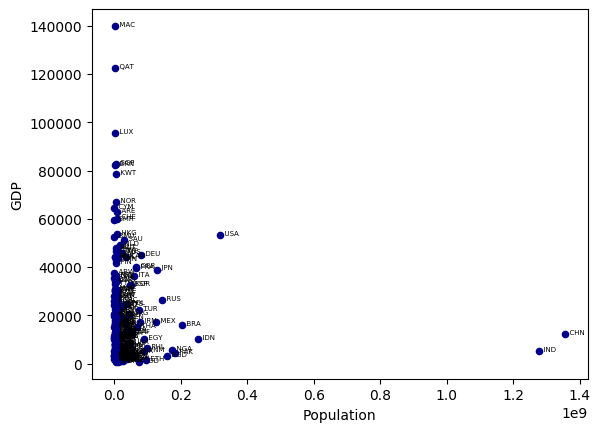

In [6]:
# E.g. in Pandas (this is a shortcut that uses matplotlib)
fig, ax = plt.subplots()
df.plot(x='Population',y='GDP',c='DarkBlue', kind='scatter',ax=ax)
for i, point in df.iterrows():     # NB this iterates over rows; i is the row index and point is an array with the rest of the row
    plt.annotate(str('  ')+str(point['Country Code']),(point['Population'], point['GDP']),fontsize=5 )
plt.show()
    

### Try logarithmic scales

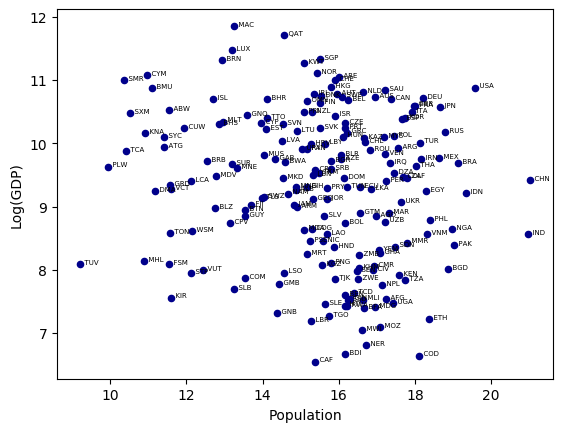

In [7]:
# Try a log plot

df1 = df.copy()
df1['Population']=np.log(df['Population'].values[:])
df1['GDP']=np.log(df['GDP'].values[:])

# E.g. in Pandas (this is a shortcut that uses matplotlib)
fig, ax = plt.subplots()
df1.plot(x='Population',y='GDP',c='DarkBlue', kind='scatter',ax=ax)
for i, point in df1.iterrows():     # NB this iterates over rows; i is the row index and point is an array with the rest of the row
    plt.annotate(str('  ')+str(point['Country Code']),(point['Population'], point['GDP']),fontsize=5 )

# plt.xlabel('Log(Population)')
plt.ylabel('Log(GDP)')
plt.show()


### Plot GDP per capita against population, on log scales

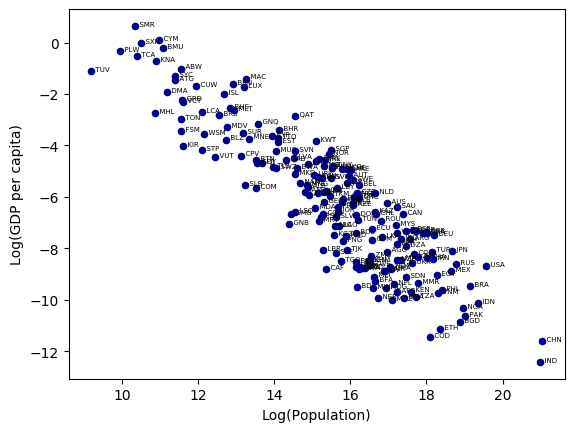

In [8]:
# Calculate GDP per capita and add to dataframe
df2 = df.copy()
gdp_per_cap = df2['GDP'].values[:] / df2['Population'].values[:]
df2['GDP per capita'] = gdp_per_cap
df2.drop(columns = ['GDP'],inplace=True)

# Take logs of population and GDP/c
df2['Population']=np.log(df2['Population'].values[:])
df2['GDP per capita']=np.log(df2['GDP per capita'].values[:])
df2.rename(columns = {'Population':'Log(Population)', 'GDP per capita':'Log(GDP per capita)'},inplace=True)

# Plot
fig, ax = plt.subplots()
df2.plot(x='Log(Population)',y='Log(GDP per capita)',c='DarkBlue', kind='scatter',ax=ax)
for i, point in df2.iterrows():     # NB this iterates over rows; i is the row index and point is an array with the rest of the row
    plt.annotate(str('  ')+str(point['Country Code']),(point['Log(Population)'], point['Log(GDP per capita)']),fontsize=5 )

plt.show()



### Apply linear regression

In [43]:
# Take features and target, and split into test and train data
feature = df2.drop(columns = 'Log(GDP per capita)')
target = df2['Log(GDP per capita)']
full_X_train, full_X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.2, random_state = 0)

X_train = full_X_train['Log(Population)'].values[:]
X_test = full_X_test['Log(Population)'].values[:]

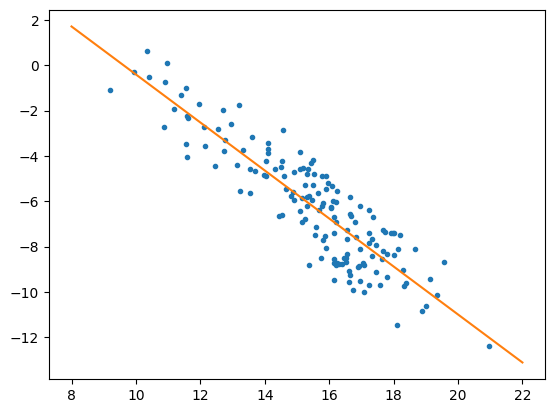

In [45]:
# Apply linear regression

model = LinearRegression()
model.fit(X_train.reshape(-1,1),y_train.values[:])
m = model.coef_
c = model.intercept_

# Plot train data and model
fig, ax = plt.subplots()
plt.plot(X_train,y_train.values[:],'.')
xs = np.linspace(8,22,2)
ys = m*xs + c
plt.plot(xs,ys)
plt.show()

### Test model

In [47]:
model.score(X_test.reshape(-1,1), y_test)

0.8405193218270761

### Predict a particular value from the test data 

In [129]:


n = 6
to_predict = full_X_train.iloc[n:n+1]
value = y_train.values[:][n]
prediction = model.predict(np.array(to_predict.values[:][0,2]).reshape(-1,1))[0]

print('Country: '+ to_predict.values[:][0,0])
print('Value: '+ str(value))
print('Prediction: '+ str(prediction))



Country: Kenya
Value: -9.676972088734443
Prediction: -8.444898030686307


### Compare the model with test and train data 

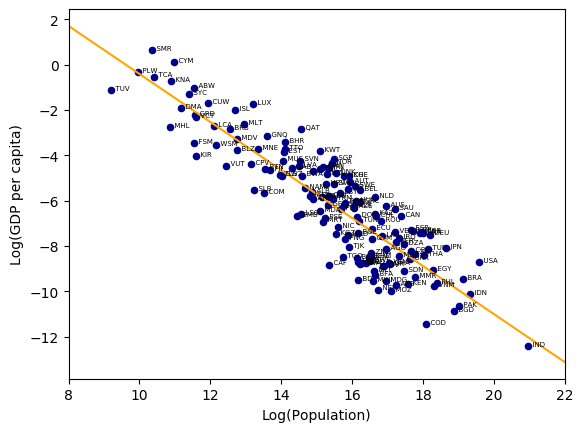

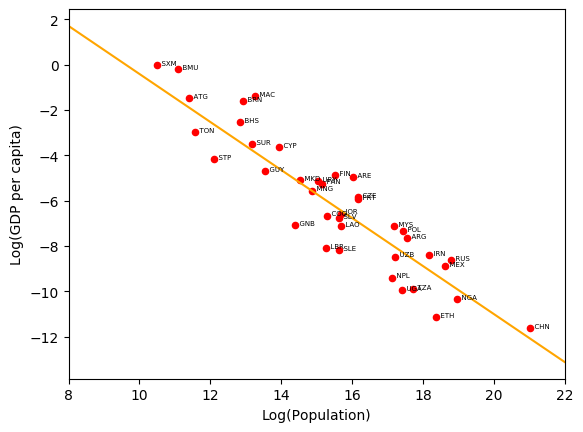

In [154]:
train_df = full_X_train
train_df['Log(GDP per capita)'] = y_train
test_df = full_X_test
test_df['Log(GDP per capita)'] = y_test

fig, ax = plt.subplots()
xs = np.linspace(8,22,2)
ys = m*xs + c
plt.plot(xs,ys,color='orange')
train_df.plot(x='Log(Population)',y='Log(GDP per capita)',c='DarkBlue', kind='scatter',ax=ax)
for i, point in train_df.iterrows():    
    plt.annotate(str('  ')+str(point['Country Code']),(point['Log(Population)'], point['Log(GDP per capita)']),fontsize=5)
plt.xlim(8,22)
plt.show() 

fig, ax = plt.subplots()
xs = np.linspace(8,22,2)
ys = m*xs + c
plt.plot(xs,ys,color='orange')
test_df.plot(x='Log(Population)',y='Log(GDP per capita)',c='Red', kind='scatter',ax=ax)
for i, point in test_df.iterrows():    
    plt.annotate(str('  ')+str(point['Country Code']),(point['Log(Population)'], point['Log(GDP per capita)']),fontsize=5 ) 
plt.xlim(8,22)
plt.show()



### The actual GDP-population model

If we defing $G$ as the GDP, $P$ as the population and $g = G/P$ as the GDP per capita, then the model reads $\log g = w \log P + b$. This corresponds to a GDP-population relationship of $G = e^b P^{w+1}$. We find that $w$ is slightly less than -1, corresponding to an inverse relationship between GDP and population with a small exponent. 

This fit seems to successfully account for small countries that have large GDPs (e.q. Qatar, Macao, Luxembourg) as well as large countries that have a relatively small GDPs (mainly India and China). In a third paradigm, there are countries which seem to have a GDP that is roughly proportional to their populations, such as Russia, Japan and the USA. These points are not fit so well by the model.

One point to note is that the inclusion of small, wealthy territories/administrive regions of countries (e.g. Hong Kong, Macao, the Cayman islands) skew the data in a way that favours an inverse relationship. I'm also not actually sure if their GDP's also contribute to those of their "parent countries" in the data set; this double-counting may be a problem in itself.

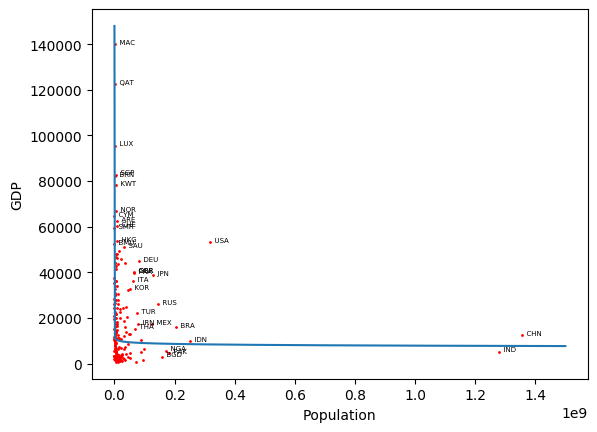

In [247]:
fig, ax = plt.subplots()
df.plot(x='Population',y='GDP',c='Red', kind='scatter',ax=ax,s=1)
for i, point in df.iterrows():   
    if point['GDP']>50*10**3:  
        plt.annotate(str('  ')+str(point['Country Code']),(point['Population'], point['GDP']),fontsize=5 ) 
    elif point['Population']>0.15*10**9:  
        plt.annotate(str('  ')+str(point['Country Code']),(point['Population'], point['GDP']),fontsize=5 ) 
    elif point['Population']>0.05*10**9 and point['GDP']>15*10**3:
        plt.annotate(str('  ')+str(point['Country Code']),(point['Population'], point['GDP']),fontsize=5 )   
    if point['Country Code']=='GBR':
        plt.annotate(str('  ')+str(point['Country Code']),(point['Population'], point['GDP']),fontsize=5 )             
xs = np.linspace(1*10**(-13),1.5*10**9,1000)
ax.plot(xs,np.exp(c)*xs**(m[0]+1),c='C0')
plt.show()
